In [1]:
import pickle
import numpy as np
import torch
import pandas as pd
from torch import nn

In [2]:
TRAIN = True

In [3]:
a = pd.read_csv('../processed_data/fluorescence_dataset.csv')
a = pd.read_excel('../raw_data/41592_2018_45_MOESM4_ESM.xlsx', skiprows=6, engine='openpyxl')
a.rename(columns={'Standard Name':'gene', 'Systematic Name':"systematicName"}, inplace=True)

b = pd.read_csv('../processed_data/yamanishi_data.csv', header = 0)

/home/vaslem/code/intbioproj/.venv/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [4]:
def transform(x):
    x = x.copy()
    x[x<=0] = 0.01 
    return np.log10(x)
def normalize(x):
    return (x - x.min())/(x.max() - x.min())
c = a.merge(b, on='gene')
c.intensity_x = normalize(transform(c.intensity_x))
c['intensity.1'] = normalize(transform(c['intensity.1']))
c['intensity.2'] = normalize(transform(c['intensity.2']))
c['intensity_y'] = normalize(transform(c['intensity_y']))
c['fold_bkg'] = transform(c['fold_bkg'])
c['fold_bkg.1'] = transform(c['fold_bkg.1'])
c['fold_bkg.2'] = transform(c['fold_bkg.2'])

c['diff1'] =  c.intensity_x - c['intensity.1']
c['diff2'] =  c.intensity_x - c['intensity.2']
c['diff3'] =  c.fold_bkg - c['fold_bkg.1']
c['diff4'] =  c.fold_bkg - c['fold_bkg.2']
c['div1'] =  c.intensity_x / c['intensity.1']
c['div2'] =  c.intensity_x / c['intensity.2']
c['div3'] =  c.fold_bkg / c['fold_bkg.1']
c['div4'] =  c.fold_bkg / c['fold_bkg.2']

c.corr()['intensity_y'].sort_values()

div2           0.035089
div4           0.044465
diff1          0.071672
intensity.2    0.073393
div1           0.081652
diff2          0.103972
fold_bkg.2     0.135199
intensity.1    0.148385
fold_bkg.1     0.156987
div3           0.170411
intensity_x    0.177065
diff4          0.195595
fold_bkg       0.223439
diff3          0.360136
intensity_y    1.000000
Name: intensity_y, dtype: float64

In [5]:
c['diff3'].describe()

count    3992.000000
mean       -0.064435
std         0.099830
min        -0.989659
25%        -0.098950
50%        -0.041393
75%        -0.007825
max         0.672838
Name: diff3, dtype: float64

In [6]:
to_use = transform(a.fold_bkg) - transform(a['fold_bkg.1'])
to_use.index = a.gene
to_use.name = 'intensity'

<AxesSubplot:>

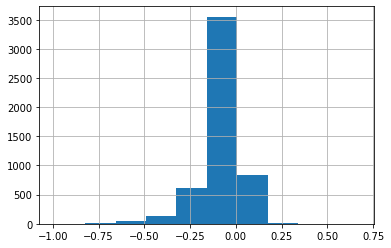

In [7]:
to_use.hist()

In [8]:
to_use.min(), to_use.max()

(-0.9896591666617807, 0.6728378625060083)

In [9]:
to_use.describe()

count    5214.000000
mean       -0.072626
std         0.114017
min        -0.989659
25%        -0.105891
50%        -0.043275
75%        -0.007969
max         0.672838
Name: intensity, dtype: float64

In [10]:
to_use

gene
SSA1    -0.220307
ERP2    -0.088624
FUN14   -0.075380
SPO7     0.018483
MDM10         NaN
           ...   
NaN     -0.041393
SGE1    -0.037789
ARR1    -0.020685
ARR2    -0.082670
ARR3    -0.030669
Name: intensity, Length: 5254, dtype: float64

In [11]:
FIL = 'utrs_embeddings_6_10_50'
Y_ID = ''
fDf = to_use.reset_index()
seqs = pd.read_csv('../processed_data/utrs.csv')
seqs = seqs[['Gene Name', 'foreign']].dropna(axis=0).rename(columns={'Gene Name': 'gene', 'foreign':'utr_seq'})
fDf = seqs.merge(fDf, on='gene', how='left')
with open(f'../processed_data/{FIL}{Y_ID}.pkl', 'rb') as inp:
    [genes, tokenized, embedding_keys, embedding_mat] = pickle.load(inp)
fDf = fDf.set_index('gene').loc[genes,:]
checkpoint_path = f"../model/utrs_lstm_weights{Y_ID}.ckpt"
# tokenized = [s for s,g in zip(tokenized, seq_geneset_mask) if g]
# fDf = fDf.set_index('gene').loc[seq_geneset, :].reset_index()
# mask = fDf['intensity'] > 0 # negative intensities make no sense
# print(f"Removing {sum(~mask)} rows that have negative intensity")
# fDf = fDf[mask]
# tokenized = [x for m,x in zip(mask, tokenized) if m]
len(fDf), len(tokenized)

(4869, 4869)

In [12]:
fDf

,utr_seq,intensity
gene,,
VPS8,ACATTTCTAAATATTTAATACAACTTTGGTTACATAAAAGTAAAAT...,NaN
SSA1,AGCCAATTGGTGCGGCAATTGATAATAACGAAAATGTCTTTTAATG...,-0.220307
ERP2,AGAACTTTTCAATCTACGAAAAATATATGTCCGCAATATAGAACAC...,-0.088624
FUN14,AGCAAGACAAATGACCAGATATAAACGAGGGTTATATTCTTTCGTT...,-0.075380
SPO7,AAAGAGTTGGAGGGCTTCTTCCTTCGAATAAGAGGTCATATTTACC...,0.018483
...,...,...
TKL1,AATTCTGATCGTAGATCATCAGATTTGATATGATATTATTTGTGAA...,0.009075
MRL1,AACAATGCATACTTTGTACGTTCAAAATACAATGCAGTAGATATAT...,-0.024208
GRS2,ACTGAAAAAAGAGGGGAATTTTTAGATACTGAAATGATATTTTAGA...,-0.090570


In [13]:
mask = ~fDf['intensity'].isnull()
fDf = fDf[mask]
tokenized = [x for m,x in zip(mask, tokenized) if m]
# fDf['logInt'] = np.log(fDf['intensity'])
# maskLog = fDf['logInt']>-20
# print(f"Removing {sum(~maskLog)} rows that have outliers log Intensity values <= -20")
# fDf = fDf[fDf['logInt']>-20]
# tokenized = [x for m,x in zip(maskLog, tokenized) if m]
# y = fDf['logInt'].copy()

y = fDf['intensity'].copy()
len(fDf), len(tokenized)

(3734, 3734)

In [14]:
y_dig = np.digitize(y, np.quantile(y, np.arange(0,1,0.2)))
mask0 = y_dig == 1
mask1 = y_dig == 5

mask = mask0 | mask1
x = [t for (t,m) in zip(tokenized,mask) if m]
y_bin = y_dig[mask] ==5
len(x), y_bin.shape[0]

(1581, 1581)

In [15]:
from tensorflow.keras.utils import to_categorical
from tensorflow.ragged import constant
import os
import tensorflow as tf

In [16]:
from tensorflow.keras.optimizers import Adam

In [17]:
# Tensorflow 1.9; Keras 2.2.0 (latest versions)
# should be backwards compatible upto Keras 2.0.9 and tf 1.5
from keras.models import Model
from keras.layers import *
import numpy as np
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
def create_models():
    #Get a sequence of indexes of words as input:
    # Keras supports dynamic input lengths if you provide (None,) as the 
    #  input shape
    inp = Input((None,))
    #Embed words into vectors of size 10 each:
    # Output shape is (None,10)
    
    embs = Embedding(embedding_mat.shape[0],
                            embedding_mat.shape[1],
                            weights=[embedding_mat],
                            trainable=False)(inp)
    dropout = SpatialDropout1D(0.2)(embs)
    # Run LSTM on these vectors and return output on each timestep
    # Output shape is (None,5)
    lstm = Bidirectional(LSTM(10, return_sequences=True))(dropout)
    ##Attention Block
    #Transform each timestep into 1 value (attention_value) 
    # Output shape is (None,1)
    attention = TimeDistributed(Dense(1))(lstm)
    #By running softmax on axis 1 we force attention_values
    # to sum up to 1. We are effectively assigning a "weight" to each timestep
    # Output shape is still (None,1) but each value changes
    attention_vals = Softmax(axis=1, dtype='float32')(attention)
    # Multiply the encoded timestep by the respective weight
    # I.e. we are scaling each timestep based on its weight
    # Output shape is (None,5): (None,5)*(None,1)=(None,5)
    scaled_vecs = Multiply()([lstm,attention_vals])
    # Sum up all scaled timesteps into 1 vector 
    # i.e. obtain a weighted sum of timesteps
    # Output shape is (5,) : Observe the time dimension got collapsed
    context_vector = Lambda(lambda x: tf.keras.backend.sum(x,axis=1))(scaled_vecs)
    ##Attention Block over
    # Get the output out
    x = Dense(1)(context_vector)
    out = Activation('sigmoid', dtype='float32', name='predictions')(x)
    model = Model(inp, out)
    model_with_attention_output = Model(inp, [out, attention_vals])
    model.compile(optimizer=Adam(learning_rate=1e-3),loss='binary_crossentropy', metrics=['accuracy'])
    return model, model_with_attention_output

model,model_with_attention_output = create_models()
model.summary()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070, compute capability 7.5


2021-12-05 20:49:40.025904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 20:49:40.031906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 20:49:40.032109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 20:49:40.033375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 20:49:40.040854: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized wit

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 50)     250100      ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, None, 50)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, None, 20)     4880        ['spatial_dropout1d[0][0]']  

In [18]:
from keras.preprocessing.sequence import pad_sequences

In [19]:
if TRAIN:
    from sklearn.model_selection import train_test_split
    x_train, x_valid, y_train, y_valid = train_test_split(x, y_bin, test_size=0.1)
    y_train.shape, y_valid.shape

In [20]:
if TRAIN:
    seq_len = max([len(x) for x in x_train])
    seq_len

In [22]:
if TRAIN:
    model,model_with_attention_output = create_models()
    padded = pad_sequences(x,seq_len,value=-1)

    # Create a callback that saves the model's weights
    
    ts_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + '_train',
                                                     save_weights_only=True,save_best_only=True,
                                                     monitor='accuracy',
                                                     verbose=1)
    vs_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + '_val',
                                                     save_weights_only=True,save_best_only=True,
                                                     monitor='val_accuracy',
                                                     verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=30, verbose=0,
        mode='auto', baseline=None, restore_best_weights=False
    )
    history = model.fit(
        padded,
        np.array(y_bin),
        batch_size=32, epochs=1000,
        callbacks=[vs_callback, ts_callback, es_callback],
        validation_data=(constant([np.array(t) for t in x_valid],dtype='int16'),
        np.array(y_valid)),validation_batch_size=int(0.1 * y_bin.size))


Epoch 1/1000


2021-12-05 20:50:35.489973: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


50/50 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.5414
Epoch 00001: val_accuracy improved from -inf to 0.51572, saving model to ../model/utrs_lstm_weights.ckpt_val

Epoch 00001: accuracy improved from -inf to 0.54143, saving model to ../model/utrs_lstm_weights.ckpt_train
50/50 [==============================] - 8s 99ms/step - loss: 0.6916 - accuracy: 0.5414 - val_loss: 0.6970 - val_accuracy: 0.5157
Epoch 2/1000
50/50 [==============================] - ETA: 0s - loss: 0.6889 - accuracy: 0.5503
Epoch 00002: val_accuracy did not improve from 0.51572

Epoch 00002: accuracy improved from 0.54143 to 0.55028, saving model to ../model/utrs_lstm_weights.ckpt_train
50/50 [==============================] - 4s 71ms/step - loss: 0.6889 - accuracy: 0.5503 - val_loss: 0.7345 - val_accuracy: 0.4843
Epoch 3/1000
50/50 [==============================] - ETA: 0s - loss: 0.6857 - accuracy: 0.5478
Epoch 00003: val_accuracy did not improve from 0.51572

Epoch 00003: accuracy did 

50/50 [==============================] - ETA: 0s - loss: 0.5443 - accuracy: 0.7369
Epoch 00021: val_accuracy improved from 0.73585 to 0.76101, saving model to ../model/utrs_lstm_weights.ckpt_val

Epoch 00021: accuracy improved from 0.72676 to 0.73688, saving model to ../model/utrs_lstm_weights.ckpt_train
50/50 [==============================] - 4s 72ms/step - loss: 0.5443 - accuracy: 0.7369 - val_loss: 0.5261 - val_accuracy: 0.7610
Epoch 22/1000
50/50 [==============================] - ETA: 0s - loss: 0.5305 - accuracy: 0.7470
Epoch 00022: val_accuracy did not improve from 0.76101

Epoch 00022: accuracy improved from 0.73688 to 0.74700, saving model to ../model/utrs_lstm_weights.ckpt_train
50/50 [==============================] - 4s 71ms/step - loss: 0.5305 - accuracy: 0.7470 - val_loss: 0.4937 - val_accuracy: 0.7610
Epoch 23/1000
50/50 [==============================] - ETA: 0s - loss: 0.5216 - accuracy: 0.7457
Epoch 00023: val_accuracy improved from 0.76101 to 0.78616, saving model t

50/50 [==============================] - ETA: 0s - loss: 0.4297 - accuracy: 0.8166
Epoch 00043: val_accuracy did not improve from 0.84906

Epoch 00043: accuracy improved from 0.81341 to 0.81657, saving model to ../model/utrs_lstm_weights.ckpt_train
50/50 [==============================] - 4s 72ms/step - loss: 0.4297 - accuracy: 0.8166 - val_loss: 0.3051 - val_accuracy: 0.8491
Epoch 44/1000
50/50 [==============================] - ETA: 0s - loss: 0.4425 - accuracy: 0.8001
Epoch 00044: val_accuracy did not improve from 0.84906

Epoch 00044: accuracy did not improve from 0.81657
50/50 [==============================] - 4s 71ms/step - loss: 0.4425 - accuracy: 0.8001 - val_loss: 0.3062 - val_accuracy: 0.8428
Epoch 45/1000
50/50 [==============================] - ETA: 0s - loss: 0.4266 - accuracy: 0.8140
Epoch 00045: val_accuracy improved from 0.84906 to 0.85535, saving model to ../model/utrs_lstm_weights.ckpt_val

Epoch 00045: accuracy did not improve from 0.81657
50/50 [===================

Epoch 65/1000
50/50 [==============================] - ETA: 0s - loss: 0.3642 - accuracy: 0.8431
Epoch 00065: val_accuracy improved from 0.91824 to 0.92453, saving model to ../model/utrs_lstm_weights.ckpt_val

Epoch 00065: accuracy did not improve from 0.85199
50/50 [==============================] - 4s 71ms/step - loss: 0.3642 - accuracy: 0.8431 - val_loss: 0.2009 - val_accuracy: 0.9245
Epoch 66/1000
50/50 [==============================] - ETA: 0s - loss: 0.3679 - accuracy: 0.8419
Epoch 00066: val_accuracy did not improve from 0.92453

Epoch 00066: accuracy did not improve from 0.85199
50/50 [==============================] - 4s 71ms/step - loss: 0.3679 - accuracy: 0.8419 - val_loss: 0.2220 - val_accuracy: 0.8931
Epoch 67/1000
50/50 [==============================] - ETA: 0s - loss: 0.3553 - accuracy: 0.8514
Epoch 00067: val_accuracy did not improve from 0.92453

Epoch 00067: accuracy did not improve from 0.85199
50/50 [==============================] - 4s 71ms/step - loss: 0.3553 - 

Epoch 88/1000
50/50 [==============================] - ETA: 0s - loss: 0.3193 - accuracy: 0.8729
Epoch 00088: val_accuracy improved from 0.96226 to 0.97484, saving model to ../model/utrs_lstm_weights.ckpt_val

Epoch 00088: accuracy did not improve from 0.87476
50/50 [==============================] - 4s 71ms/step - loss: 0.3193 - accuracy: 0.8729 - val_loss: 0.1375 - val_accuracy: 0.9748
Epoch 89/1000
50/50 [==============================] - ETA: 0s - loss: 0.3187 - accuracy: 0.8672
Epoch 00089: val_accuracy did not improve from 0.97484

Epoch 00089: accuracy did not improve from 0.87476
50/50 [==============================] - 4s 71ms/step - loss: 0.3187 - accuracy: 0.8672 - val_loss: 0.1465 - val_accuracy: 0.9560
Epoch 90/1000
50/50 [==============================] - ETA: 0s - loss: 0.3045 - accuracy: 0.8729
Epoch 00090: val_accuracy did not improve from 0.97484

Epoch 00090: accuracy did not improve from 0.87476
50/50 [==============================] - 4s 71ms/step - loss: 0.3045 - 

Epoch 112/1000
50/50 [==============================] - ETA: 0s - loss: 0.2912 - accuracy: 0.8792
Epoch 00112: val_accuracy did not improve from 0.97484

Epoch 00112: accuracy did not improve from 0.88868
50/50 [==============================] - 3s 69ms/step - loss: 0.2912 - accuracy: 0.8792 - val_loss: 0.1438 - val_accuracy: 0.9560
Epoch 113/1000
50/50 [==============================] - ETA: 0s - loss: 0.2901 - accuracy: 0.8741
Epoch 00113: val_accuracy did not improve from 0.97484

Epoch 00113: accuracy did not improve from 0.88868
50/50 [==============================] - 4s 72ms/step - loss: 0.2901 - accuracy: 0.8741 - val_loss: 0.1183 - val_accuracy: 0.9623
Epoch 114/1000
50/50 [==============================] - ETA: 0s - loss: 0.2869 - accuracy: 0.8729
Epoch 00114: val_accuracy did not improve from 0.97484

Epoch 00114: accuracy did not improve from 0.88868
50/50 [==============================] - 4s 71ms/step - loss: 0.2869 - accuracy: 0.8729 - val_loss: 0.1274 - val_accuracy: 0.

Epoch 136/1000
50/50 [==============================] - ETA: 0s - loss: 0.2606 - accuracy: 0.8963
Epoch 00136: val_accuracy did not improve from 0.98113

Epoch 00136: accuracy improved from 0.89437 to 0.89627, saving model to ../model/utrs_lstm_weights.ckpt_train
50/50 [==============================] - 4s 73ms/step - loss: 0.2606 - accuracy: 0.8963 - val_loss: 0.0922 - val_accuracy: 0.9811
Epoch 137/1000
50/50 [==============================] - ETA: 0s - loss: 0.2764 - accuracy: 0.8925
Epoch 00137: val_accuracy did not improve from 0.98113

Epoch 00137: accuracy did not improve from 0.89627
50/50 [==============================] - 4s 73ms/step - loss: 0.2764 - accuracy: 0.8925 - val_loss: 0.1000 - val_accuracy: 0.9811
Epoch 138/1000
50/50 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.9001
Epoch 00138: val_accuracy did not improve from 0.98113

Epoch 00138: accuracy improved from 0.89627 to 0.90006, saving model to ../model/utrs_lstm_weights.ckpt_train
50/50 [

Epoch 160/1000
50/50 [==============================] - ETA: 0s - loss: 0.2470 - accuracy: 0.9045
Epoch 00160: val_accuracy did not improve from 0.98742

Epoch 00160: accuracy did not improve from 0.91714
50/50 [==============================] - 3s 69ms/step - loss: 0.2470 - accuracy: 0.9045 - val_loss: 0.0817 - val_accuracy: 0.9874
Epoch 161/1000
50/50 [==============================] - ETA: 0s - loss: 0.2421 - accuracy: 0.8988
Epoch 00161: val_accuracy did not improve from 0.98742

Epoch 00161: accuracy did not improve from 0.91714
50/50 [==============================] - 3s 69ms/step - loss: 0.2421 - accuracy: 0.8988 - val_loss: 0.0991 - val_accuracy: 0.9748
Epoch 162/1000
50/50 [==============================] - ETA: 0s - loss: 0.2477 - accuracy: 0.8994
Epoch 00162: val_accuracy did not improve from 0.98742

Epoch 00162: accuracy did not improve from 0.91714
50/50 [==============================] - 4s 72ms/step - loss: 0.2477 - accuracy: 0.8994 - val_loss: 0.1122 - val_accuracy: 0.

50/50 [==============================] - ETA: 0s - loss: 0.2442 - accuracy: 0.9032
Epoch 00184: val_accuracy did not improve from 0.98742

Epoch 00184: accuracy did not improve from 0.92853
50/50 [==============================] - 4s 70ms/step - loss: 0.2442 - accuracy: 0.9032 - val_loss: 0.0757 - val_accuracy: 0.9811
Epoch 185/1000
50/50 [==============================] - ETA: 0s - loss: 0.2365 - accuracy: 0.9001
Epoch 00185: val_accuracy did not improve from 0.98742

Epoch 00185: accuracy did not improve from 0.92853
50/50 [==============================] - 3s 70ms/step - loss: 0.2365 - accuracy: 0.9001 - val_loss: 0.0728 - val_accuracy: 0.9874
Epoch 186/1000
50/50 [==============================] - ETA: 0s - loss: 0.2501 - accuracy: 0.9020
Epoch 00186: val_accuracy did not improve from 0.98742

Epoch 00186: accuracy did not improve from 0.92853
50/50 [==============================] - 3s 69ms/step - loss: 0.2501 - accuracy: 0.9020 - val_loss: 0.0765 - val_accuracy: 0.9811
Epoch 187/

Epoch 209/1000
50/50 [==============================] - ETA: 0s - loss: 0.2523 - accuracy: 0.9026
Epoch 00209: val_accuracy did not improve from 0.99371

Epoch 00209: accuracy did not improve from 0.92853
50/50 [==============================] - 4s 71ms/step - loss: 0.2523 - accuracy: 0.9026 - val_loss: 0.0767 - val_accuracy: 0.9748
Epoch 210/1000
50/50 [==============================] - ETA: 0s - loss: 0.2221 - accuracy: 0.9102
Epoch 00210: val_accuracy did not improve from 0.99371

Epoch 00210: accuracy did not improve from 0.92853
50/50 [==============================] - 4s 71ms/step - loss: 0.2221 - accuracy: 0.9102 - val_loss: 0.0696 - val_accuracy: 0.9811
Epoch 211/1000
50/50 [==============================] - ETA: 0s - loss: 0.2608 - accuracy: 0.8969
Epoch 00211: val_accuracy did not improve from 0.99371

Epoch 00211: accuracy did not improve from 0.92853
50/50 [==============================] - 4s 71ms/step - loss: 0.2608 - accuracy: 0.8969 - val_loss: 0.0676 - val_accuracy: 0.

50/50 [==============================] - ETA: 0s - loss: 0.2059 - accuracy: 0.9216
Epoch 00233: val_accuracy did not improve from 0.99371

Epoch 00233: accuracy did not improve from 0.93232
50/50 [==============================] - 4s 71ms/step - loss: 0.2059 - accuracy: 0.9216 - val_loss: 0.0596 - val_accuracy: 0.9874
Epoch 234/1000
50/50 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 0.9190
Epoch 00234: val_accuracy did not improve from 0.99371

Epoch 00234: accuracy did not improve from 0.93232
50/50 [==============================] - 3s 70ms/step - loss: 0.2007 - accuracy: 0.9190 - val_loss: 0.0531 - val_accuracy: 0.9874
Epoch 235/1000
50/50 [==============================] - ETA: 0s - loss: 0.2306 - accuracy: 0.9102
Epoch 00235: val_accuracy did not improve from 0.99371

Epoch 00235: accuracy did not improve from 0.93232
50/50 [==============================] - 4s 70ms/step - loss: 0.2306 - accuracy: 0.9102 - val_loss: 0.0606 - val_accuracy: 0.9874
Epoch 236/

Epoch 258/1000
50/50 [==============================] - ETA: 0s - loss: 0.1981 - accuracy: 0.9260
Epoch 00258: val_accuracy did not improve from 0.99371

Epoch 00258: accuracy did not improve from 0.93801
50/50 [==============================] - 4s 74ms/step - loss: 0.1981 - accuracy: 0.9260 - val_loss: 0.0542 - val_accuracy: 0.9874
Epoch 259/1000
50/50 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.9273
Epoch 00259: val_accuracy did not improve from 0.99371

Epoch 00259: accuracy did not improve from 0.93801
50/50 [==============================] - 4s 74ms/step - loss: 0.1924 - accuracy: 0.9273 - val_loss: 0.0539 - val_accuracy: 0.9874
Epoch 260/1000
50/50 [==============================] - ETA: 0s - loss: 0.1810 - accuracy: 0.9266
Epoch 00260: val_accuracy did not improve from 0.99371

Epoch 00260: accuracy did not improve from 0.93801
50/50 [==============================] - 4s 75ms/step - loss: 0.1810 - accuracy: 0.9266 - val_loss: 0.0480 - val_accuracy: 0.

50/50 [==============================] - ETA: 0s - loss: 0.1920 - accuracy: 0.9260
Epoch 00282: val_accuracy did not improve from 0.99371

Epoch 00282: accuracy did not improve from 0.94054
50/50 [==============================] - 4s 75ms/step - loss: 0.1920 - accuracy: 0.9260 - val_loss: 0.0487 - val_accuracy: 0.9874
Epoch 283/1000
50/50 [==============================] - ETA: 0s - loss: 0.2067 - accuracy: 0.9273
Epoch 00283: val_accuracy did not improve from 0.99371

Epoch 00283: accuracy did not improve from 0.94054
50/50 [==============================] - 4s 74ms/step - loss: 0.2067 - accuracy: 0.9273 - val_loss: 0.0392 - val_accuracy: 0.9937
Epoch 284/1000
50/50 [==============================] - ETA: 0s - loss: 0.1889 - accuracy: 0.9292
Epoch 00284: val_accuracy did not improve from 0.99371

Epoch 00284: accuracy did not improve from 0.94054
50/50 [==============================] - 4s 75ms/step - loss: 0.1889 - accuracy: 0.9292 - val_loss: 0.0381 - val_accuracy: 0.9937
Epoch 285/

50/50 [==============================] - ETA: 0s - loss: 0.1898 - accuracy: 0.9292
Epoch 00306: val_accuracy did not improve from 1.00000

Epoch 00306: accuracy did not improve from 0.94181
50/50 [==============================] - 4s 74ms/step - loss: 0.1898 - accuracy: 0.9292 - val_loss: 0.0409 - val_accuracy: 0.9937
Epoch 307/1000
50/50 [==============================] - ETA: 0s - loss: 0.1803 - accuracy: 0.9254
Epoch 00307: val_accuracy did not improve from 1.00000

Epoch 00307: accuracy did not improve from 0.94181
50/50 [==============================] - 4s 74ms/step - loss: 0.1803 - accuracy: 0.9254 - val_loss: 0.0377 - val_accuracy: 0.9937
Epoch 308/1000
50/50 [==============================] - ETA: 0s - loss: 0.1781 - accuracy: 0.9367
Epoch 00308: val_accuracy did not improve from 1.00000

Epoch 00308: accuracy did not improve from 0.94181
50/50 [==============================] - 4s 74ms/step - loss: 0.1781 - accuracy: 0.9367 - val_loss: 0.0395 - val_accuracy: 0.9937
Epoch 309/

50/50 [==============================] - ETA: 0s - loss: 0.1943 - accuracy: 0.9222
Epoch 00330: val_accuracy did not improve from 1.00000

Epoch 00330: accuracy did not improve from 0.94940
50/50 [==============================] - 4s 74ms/step - loss: 0.1943 - accuracy: 0.9222 - val_loss: 0.0294 - val_accuracy: 1.0000
Epoch 331/1000
50/50 [==============================] - ETA: 0s - loss: 0.1772 - accuracy: 0.9405
Epoch 00331: val_accuracy did not improve from 1.00000

Epoch 00331: accuracy did not improve from 0.94940
50/50 [==============================] - 4s 73ms/step - loss: 0.1772 - accuracy: 0.9405 - val_loss: 0.0377 - val_accuracy: 0.9937
Epoch 332/1000
50/50 [==============================] - ETA: 0s - loss: 0.1902 - accuracy: 0.9254
Epoch 00332: val_accuracy did not improve from 1.00000

Epoch 00332: accuracy did not improve from 0.94940
50/50 [==============================] - 4s 74ms/step - loss: 0.1902 - accuracy: 0.9254 - val_loss: 0.0279 - val_accuracy: 1.0000
Epoch 333/

Epoch 355/1000
50/50 [==============================] - ETA: 0s - loss: 0.1602 - accuracy: 0.9367
Epoch 00355: val_accuracy did not improve from 1.00000

Epoch 00355: accuracy did not improve from 0.94940
50/50 [==============================] - 4s 72ms/step - loss: 0.1602 - accuracy: 0.9367 - val_loss: 0.0292 - val_accuracy: 0.9937
Epoch 356/1000
50/50 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.9355
Epoch 00356: val_accuracy did not improve from 1.00000

Epoch 00356: accuracy did not improve from 0.94940
50/50 [==============================] - 3s 69ms/step - loss: 0.1678 - accuracy: 0.9355 - val_loss: 0.0398 - val_accuracy: 0.9937
Epoch 357/1000
50/50 [==============================] - ETA: 0s - loss: 0.1597 - accuracy: 0.9418
Epoch 00357: val_accuracy did not improve from 1.00000

Epoch 00357: accuracy did not improve from 0.94940
50/50 [==============================] - 4s 71ms/step - loss: 0.1597 - accuracy: 0.9418 - val_loss: 0.0372 - val_accuracy: 0.

50/50 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.9361
Epoch 00379: val_accuracy did not improve from 1.00000

Epoch 00379: accuracy did not improve from 0.95130
50/50 [==============================] - 4s 71ms/step - loss: 0.1596 - accuracy: 0.9361 - val_loss: 0.0241 - val_accuracy: 1.0000
Epoch 380/1000
50/50 [==============================] - ETA: 0s - loss: 0.1580 - accuracy: 0.9380
Epoch 00380: val_accuracy did not improve from 1.00000

Epoch 00380: accuracy did not improve from 0.95130
50/50 [==============================] - 3s 70ms/step - loss: 0.1580 - accuracy: 0.9380 - val_loss: 0.0203 - val_accuracy: 1.0000
Epoch 381/1000
50/50 [==============================] - ETA: 0s - loss: 0.1738 - accuracy: 0.9374
Epoch 00381: val_accuracy did not improve from 1.00000

Epoch 00381: accuracy did not improve from 0.95130
50/50 [==============================] - 4s 71ms/step - loss: 0.1738 - accuracy: 0.9374 - val_loss: 0.0222 - val_accuracy: 1.0000
Epoch 382/

Epoch 404/1000
50/50 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.9405
Epoch 00404: val_accuracy did not improve from 1.00000

Epoch 00404: accuracy did not improve from 0.95130
50/50 [==============================] - 4s 72ms/step - loss: 0.1596 - accuracy: 0.9405 - val_loss: 0.0374 - val_accuracy: 0.9937
Epoch 405/1000
50/50 [==============================] - ETA: 0s - loss: 0.1572 - accuracy: 0.9412
Epoch 00405: val_accuracy did not improve from 1.00000

Epoch 00405: accuracy did not improve from 0.95130
50/50 [==============================] - 4s 71ms/step - loss: 0.1572 - accuracy: 0.9412 - val_loss: 0.0283 - val_accuracy: 0.9937
Epoch 406/1000
50/50 [==============================] - ETA: 0s - loss: 0.1627 - accuracy: 0.9424
Epoch 00406: val_accuracy did not improve from 1.00000

Epoch 00406: accuracy did not improve from 0.95130
50/50 [==============================] - 4s 72ms/step - loss: 0.1627 - accuracy: 0.9424 - val_loss: 0.0331 - val_accuracy: 0.

In [23]:
if TRAIN:
    with open(f'../model/training_history{Y_ID}.pkl', 'wb') as out:
        pickle.dump(history.history, out)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


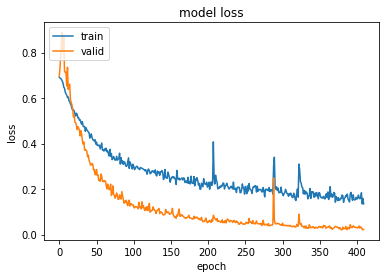

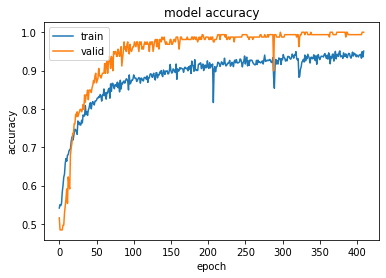

In [24]:
with open(f'../model/training_history{Y_ID}.pkl', 'rb') as inp:
    history= pickle.load(inp)
import matplotlib.pyplot as plt
# list all data in history
print(history.keys())
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [25]:
model_with_attention_output.load_weights(checkpoint_path)

In [26]:
words_importances_per_seq = model_with_attention_output.predict(constant([np.array(t) for t in tokenized],dtype='int16'),batch_size=128)[1]

In [27]:
words_importances_per_seq = words_importances_per_seq.numpy()

In [28]:
np.min([np.min(p) for p in words_importances_per_seq])

4.1940763e-07

In [29]:
np.max([np.max(p) for p in words_importances_per_seq])

1.0

In [30]:
def reconstruct_sequence(ori_seq, sub_seqs, importances):
    unseen = ori_seq
    reconstructed_importances = np.zeros(len(ori_seq))
    t1 = 0
    t0 = 0
    den_vec = np.zeros(len(ori_seq))
    nom_vec = np.zeros(len(ori_seq))
    for i,s,e in zip(importances[:-1], sub_seqs[:-1], sub_seqs[1:]):
        t0 += t1
        t1 = unseen.find(e)
        # max is used to handle gaps created due to rounding errors in k-mer partitioning (among hits of interest)
        nom_vec[t0:t0 + max(t1, len(s))] += i
        den_vec[t0:t0 + max(t1, len(s))] += 1
        unseen = unseen[t1:]
    nom_vec[-len(sub_seqs[-1]):] += importances[-1]
    den_vec[-len(sub_seqs[-1]):] += 1
    
    reconstructed_importances = nom_vec/den_vec
    return reconstructed_importances

In [36]:
def plotSignature(ind):
    print('Gene:', fDf.index[ind])
    p = reconstruct_sequence(fDf.iloc[ind]['utr_seq'], np.array(embedding_keys)[tokenized[ind]], words_importances_per_seq[ind])
    plt.figure(figsize=(60,5))
    plt.plot(p)
    _=plt.xticks(np.arange(len(fDf.iloc[ind]['utr_seq'])), list(fDf.iloc[ind]['utr_seq']))

Gene: SSA1


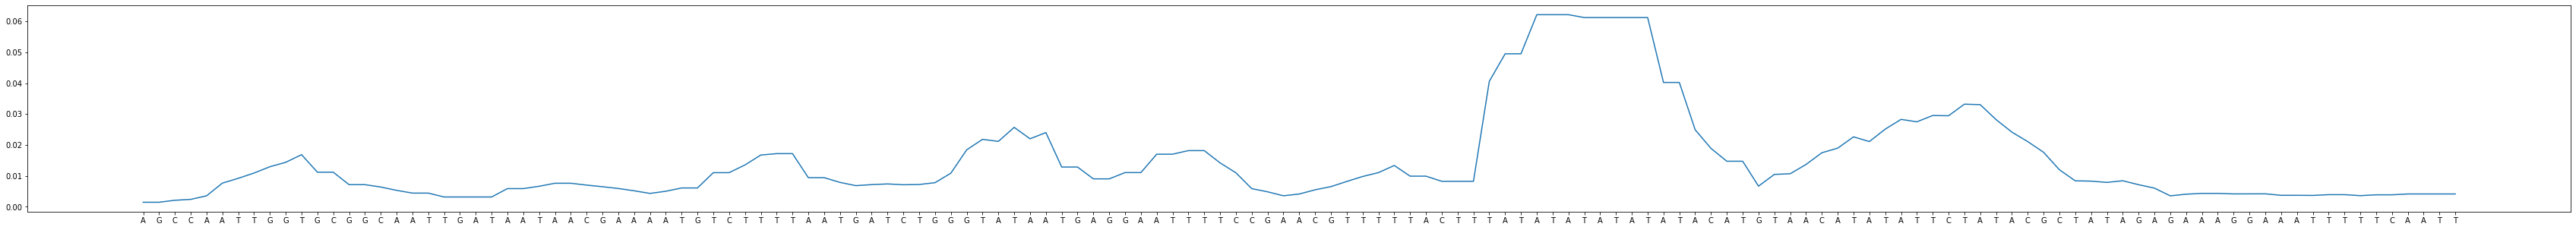

In [37]:
plotSignature(0)

Gene: ERP2


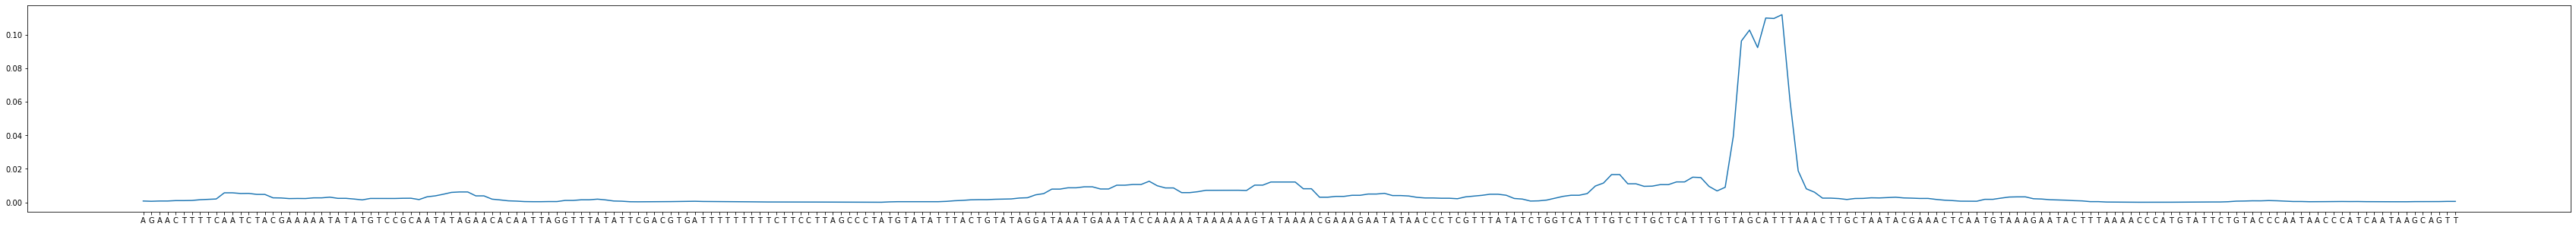

In [38]:
plotSignature(1)

Gene: FUN14


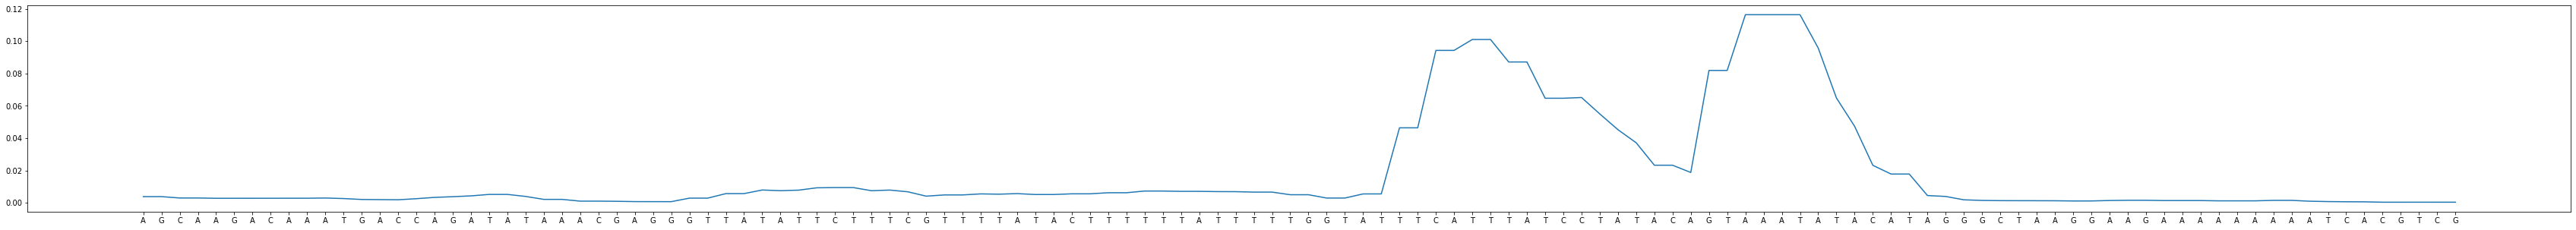

In [39]:
plotSignature(2)

Gene: SPO7


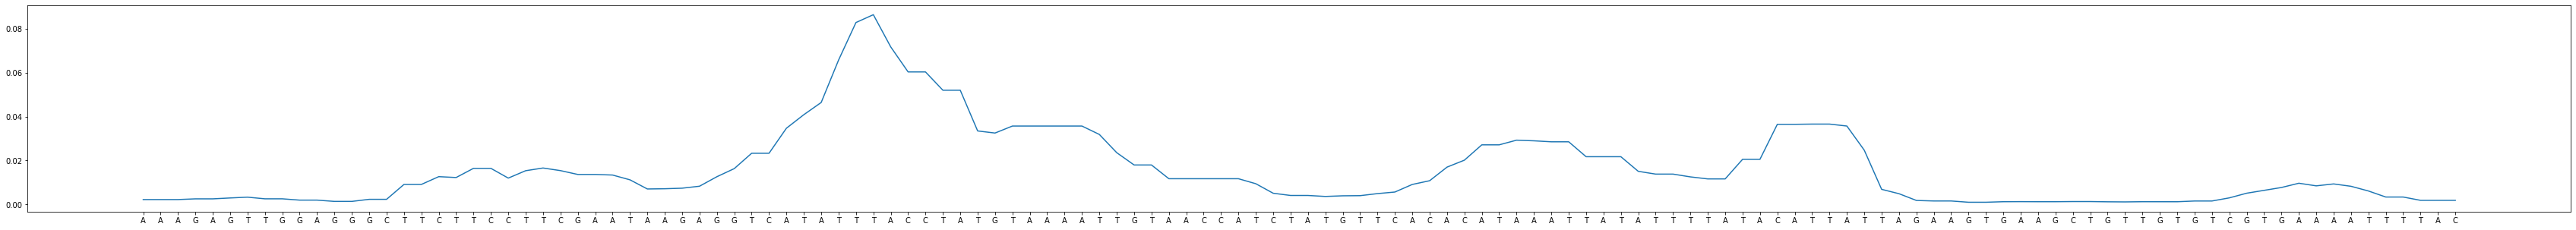

In [40]:
plotSignature(3)

Gene: SWC3


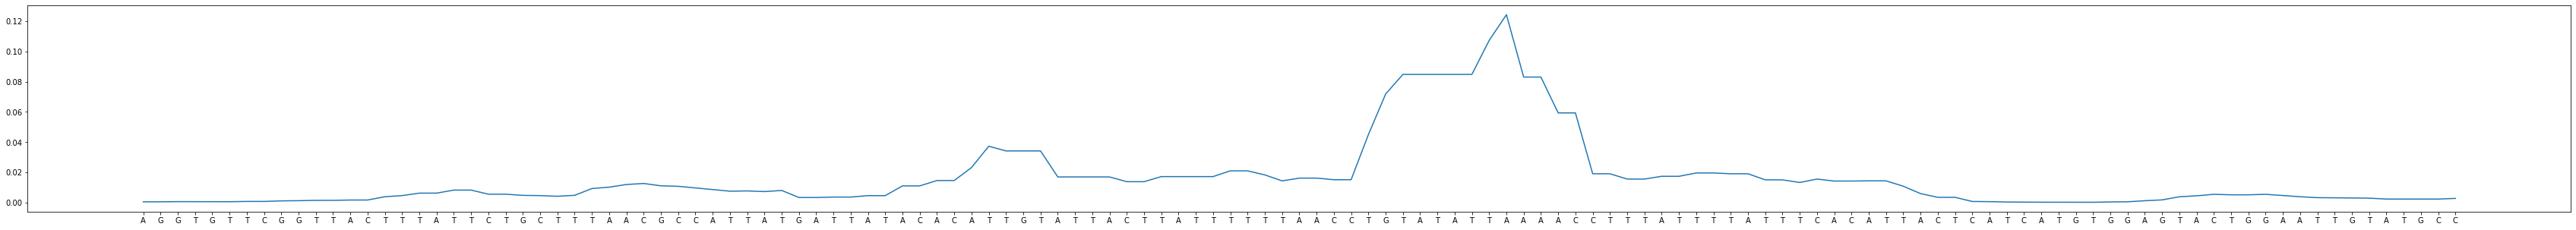

In [41]:
plotSignature(4)

Gene: CYS3


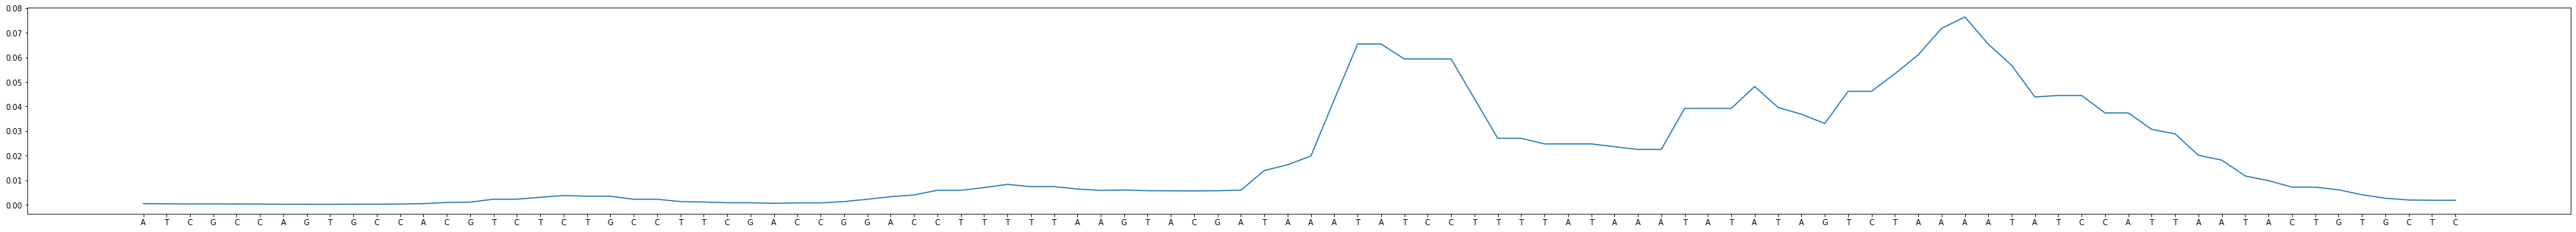

In [42]:
plotSignature(5)

Gene: DEP1


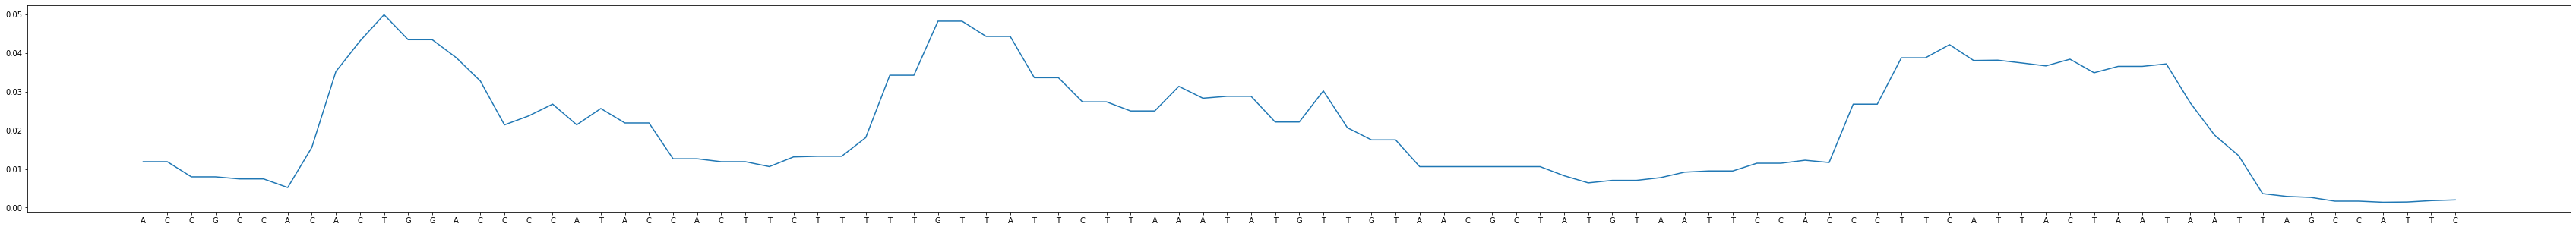

In [43]:
plotSignature(6)

Gene: NTG1


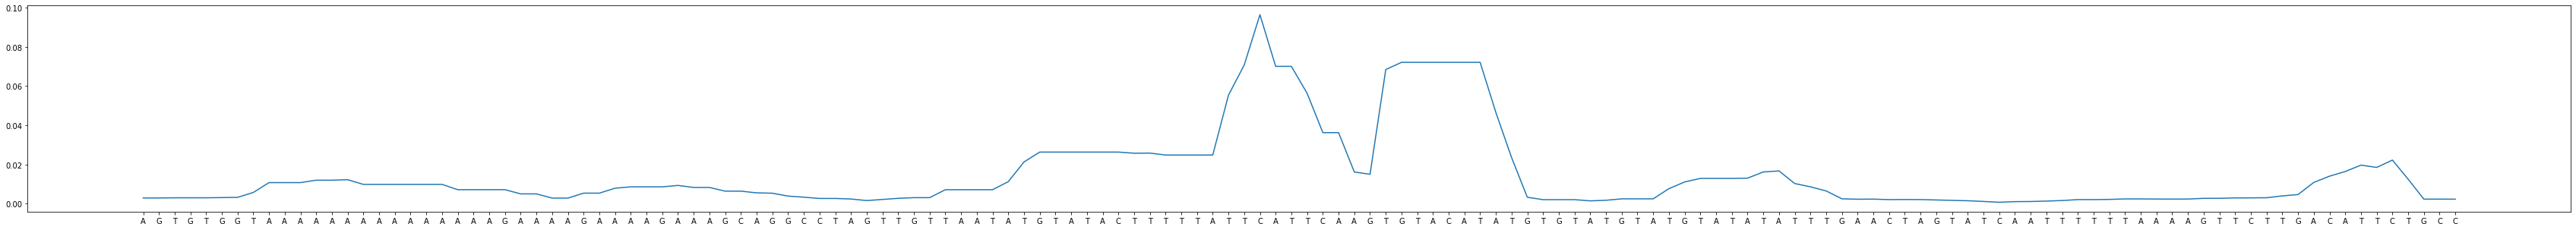

In [44]:
plotSignature(7)

Gene: TPD3


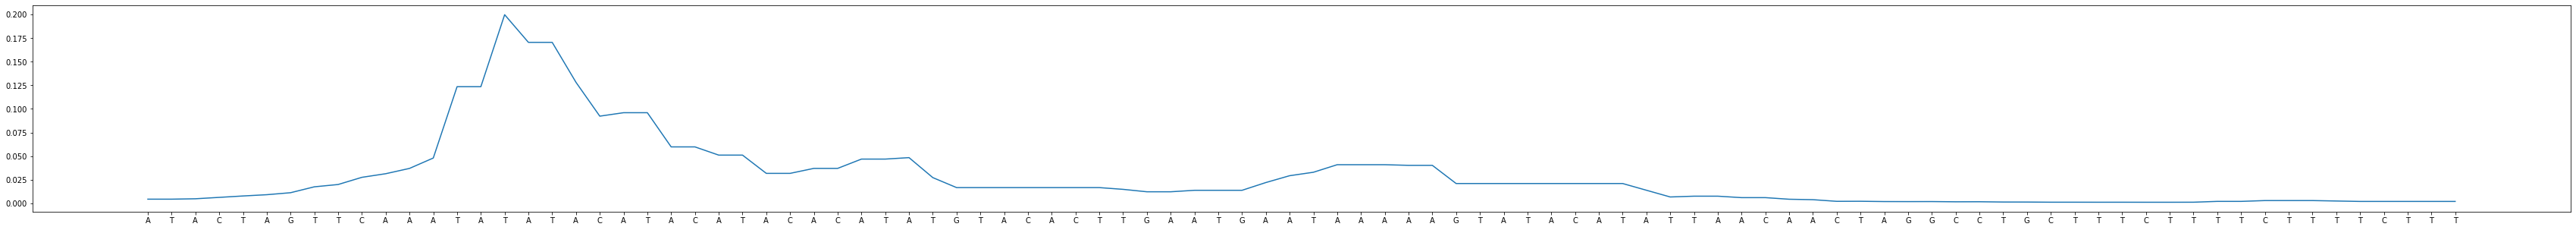

In [45]:
plotSignature(8)

In [46]:
top10i1 = np.array([np.argsort(-np.array(x).ravel(),)[:10] for x,f in zip(words_importances_per_seq, y_bin) if f==1])
top10i0 = np.array([np.argsort(-np.array(x).ravel(),)[:10] for x,f in zip(words_importances_per_seq, y_bin) if f==0])

/tmp/ipykernel_91074/3654512027.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  top10i1 = np.array([np.argsort(-np.array(x).ravel(),)[:10] for x,f in zip(words_importances_per_seq, y_bin) if f==1])
/tmp/ipykernel_91074/3654512027.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  top10i0 = np.array([np.argsort(-np.array(x).ravel(),)[:10] for x,f in zip(words_importances_per_seq, y_bin) if f==0])


### Most frequent k-mers appearing in the sequences that have been labelled with 1

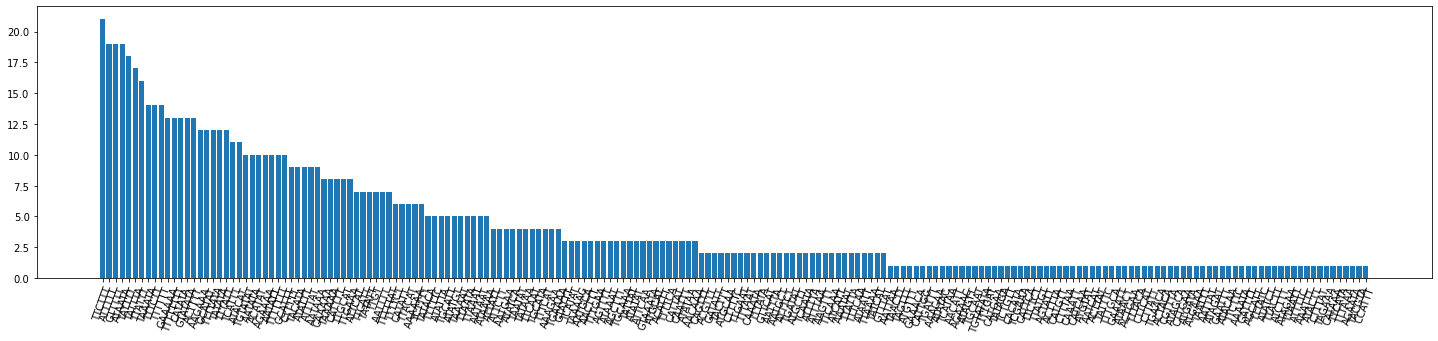

In [49]:
plt.figure(figsize=(25,5))
top1i1bins = np.bincount([x[0] for x in top10i1])
top1i1inds = np.argsort(-top1i1bins)
top1i1inds = top1i1inds[top1i1bins[top1i1inds]>0]
plt.bar(np.array(embedding_keys)[top1i1inds], top1i1bins[top1i1inds],)
_=plt.xticks(rotation=70)

### Network architecture
Architecture defined by the awesome architect in https://stackoverflow.com/questions/51477977/highlighting-important-words-in-a-sentence-using-deep-learning/51481366 with the spatial dropout addition to cater for generalization

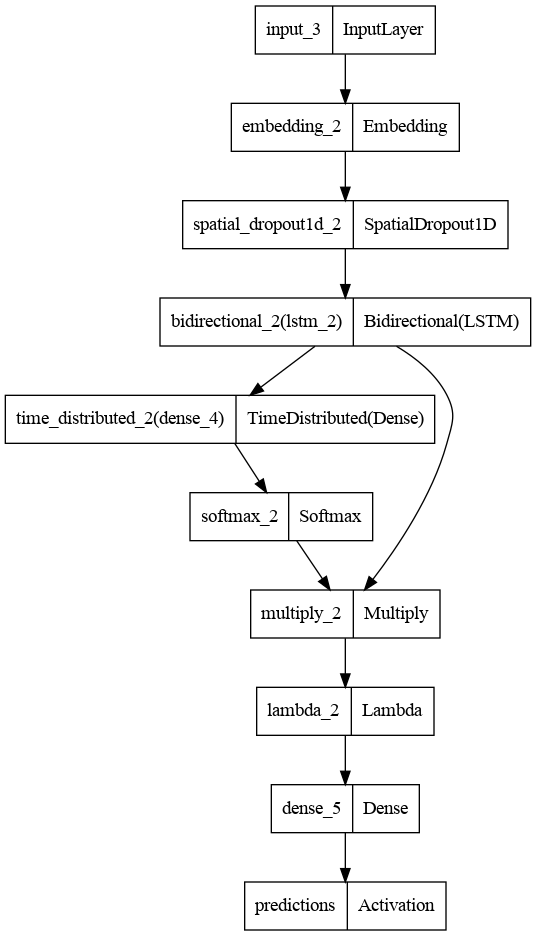

In [50]:
tf.keras.utils.plot_model(
    model, to_file='../figures/utrs_model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=False
)